The goal here is to plot out `rotSkyPos` and `rotTelPos` distributions before and after rotational dithers.

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import os
import pylab
import healpy as hp
import pandas as pd
import numpy as np
from IPython.display import Image, display
import lsst.sims.maf.db as db
import lsst.sims.maf.stackers as stackers

In [2]:
fontsize = 18
#pylab.rcParams['figure.figsize'] = (10, 6)
pylab.rcParams['axes.labelsize'] = fontsize
pylab.rcParams['xtick.labelsize'] = fontsize-2
pylab.rcParams['ytick.labelsize'] = fontsize-2
pylab.rcParams['legend.fontsize'] = fontsize
pylab.rcParams['axes.linewidth'] = 2

**Set up**

In [3]:
dbs_path = '/global/cscratch1/sd/awan/dbs_wp_unzipped'
rot_rand_seed = 42
outDir = '/global/homes/a/awan/desc/wp_descDithers_csvs/'

**Get the data**

In [4]:
# get all the files
dbfiles = [f for f in os.listdir(dbs_path) if f.endswith('db')]

In [5]:
%%time
# now read in the data
simdatas = {}
for i, dbfile in enumerate(dbfiles): # loop over all the db files
    print(dbfile)

    opsdb = db.OpsimDatabase('%s/%s'%(dbs_path, dbfile)) # connect to the database

    # WFD only
    propIds, propTags = opsdb.fetchPropInfo()
    wfdWhere = opsdb.createSQLWhere('WFD', propTags)
    # fetch the data
    colnames=['fieldRA', 'fieldDec', 'rotTelPos', 'rotSkyPos', 'night', 'filter', 'observationStartMJD', 'observationStartLST']
    simdata = opsdb.fetchMetricData(colnames=colnames, sqlconstraint=wfdWhere)
    
    # add rotational dithers: adds randomDitherPerFilterChangeRotTelPos column to simdata
    s = stackers.RandomRotDitherPerFilterChangeStacker(degrees=opsdb.raDecInDeg,
                                                       randomSeed=rot_rand_seed)
    simdata = s.run(simdata)
    
    # add parallactic angle values to the stacker: added PA column
    # needed to go from dithered rotTelPos to dithered rotSkyPos since rotSkyPos = rotTelPos - PA
    s = stackers.ParallacticAngleStacker(degrees=opsdb.raDecInDeg)
    simdata = s.run(simdata)
    simdatas[dbfile.split('.db')[0]] = simdata.copy() # not the best to do this but okay for now.

colossus_2665.db
colossus_2664.db
mothra_2045.db
kraken_2035.db
colossus_2667.db
pontus_2489.db
baseline2018a.db
kraken_2044.db
kraken_2042.db
pontus_2002.db
mothra_2049.db
kraken_2036.db
kraken_2026.db
pontus_2502.db
nexus_2097.db
CPU times: user 15min 23s, sys: 4min 2s, total: 19min 26s
Wall time: 2h 34min 42s


**Set to plot things**

In [6]:
colors = ['r', 'b', 'g', 'm', 'c',
            [0., 0., 0.],  # black
            [255/255.,0.,255/255.],  # magenta
            [255./255., 0.,0.], #[139/255., 0.,0.] # dark red
            [255/255., 105/255., 180/255.], # hot pink
            [147/255., 112/255., 219/255.], # medium purple 
            [75/255., 0., 130/255.], # indigo [255/255.,0.,255/255.]  # magenta [0., 1/255.,  34/255.] 
            [124/255., 252/255.,   0.], # lawngreen
            [34/255., 139/255.,  34/255.], # forestgreen
            [ 0/255., 255/255., 127/255.], # spring green      [0.,0.,255/255.] # blue
            [139/255., 0.,0.], # dark red
            [184/255., 134/255.,  11/255.], # dark goldenrod 
         ]

In [7]:
# want specific ordering of the dbs so write them out
dbs = ['baseline2018a', 'kraken_2026', 'kraken_2035', 'kraken_2036', 'colossus_2665', \
          'colossus_2664', 'colossus_2667', 'pontus_2002', 'pontus_2489', 'pontus_2502', 'mothra_2045', \
       'kraken_2042', 'kraken_2044', 'mothra_2049', 'nexus_2097']

**Plot**

Saved compare_rotDiths_15dbs.png


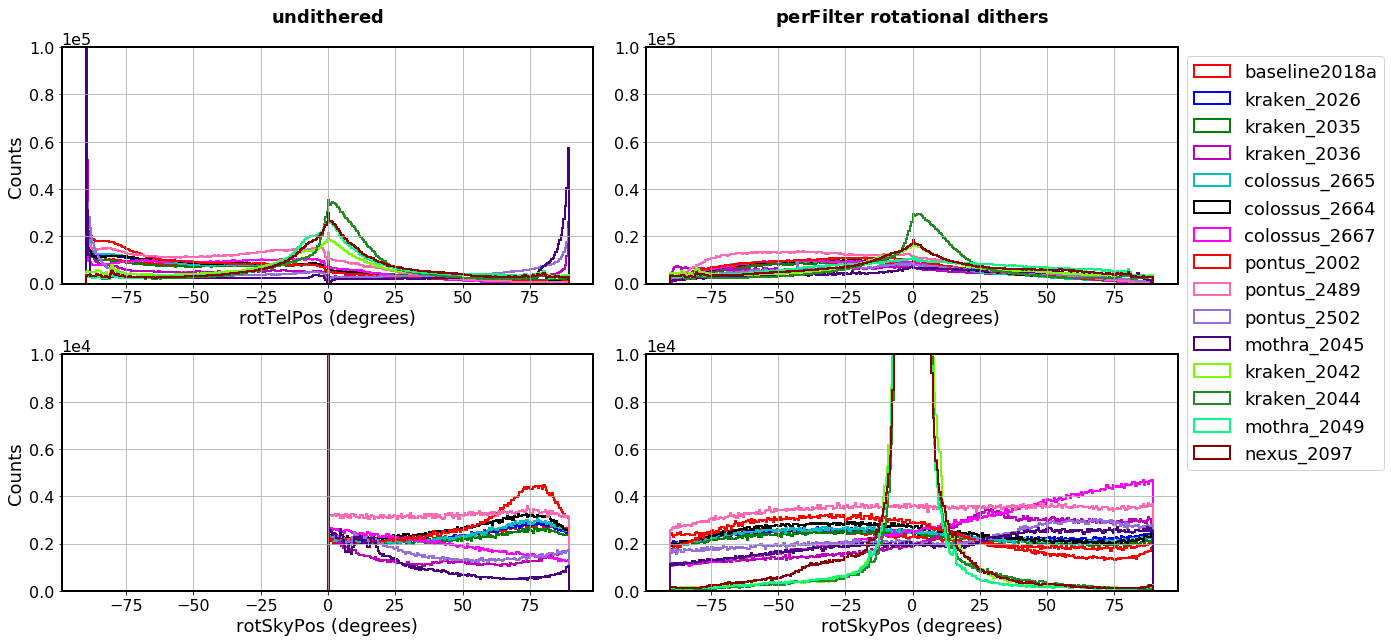

In [8]:
bins = np.arange(-90, 90, 0.5)
# histograms of dithers
nrows, ncols = 2,2
fig, axes = plt.subplots(nrows=nrows, ncols=ncols)
plt.subplots_adjust(hspace=0.3, wspace=0.1)

for i, db in enumerate(dbs):
    if db in simdatas:
        # undithered rotTelPos
        axes[0, 0].hist(simdatas[db]['rotTelPos'], bins=bins,
                        color=colors[i], histtype='step', lw=2)
        # dithered rotTelPos
        axes[0, 1].hist(simdatas[db]['randomDitherPerFilterChangeRotTelPos'],
                         label=db,
                        bins=bins, color=colors[i], histtype='step', lw=2)
        # undithered rotSkyPos
        axes[1, 0].hist(simdatas[db]['rotSkyPos'],
                        bins=bins, color=colors[i], histtype='step', lw=2)
        # dithered rotSkyPos
        axes[1, 1].hist(simdatas[db]['randomDitherPerFilterChangeRotTelPos']-simdatas[db]['PA'],
                        bins=bins, color=colors[i], histtype='step', lw=2)

#ymax_tel, ymax_sky = 0, 0
#for col in range(ncols):
#    ymax_tel = max([ymax_tel, axes[0, col].get_ylim()[-1]])
#    ymax_sky = max([ymax_sky, axes[1, col].get_ylim()[-1]])
        
ymax_tel, ymax_sky = 10**5, 10**4
for row in range(nrows):
    for col in range(ncols):
        axes[0, col].set_ylim(0, ymax_tel)
        axes[1, col].set_ylim(0, ymax_sky)
        axes[row, col].ticklabel_format(style='sci', axis='y', scilimits=(0,0))
        axes[row, 0].set_ylabel('Counts')
        axes[0, col].set_xlabel('rotTelPos (degrees)')
        axes[1, col].set_xlabel('rotSkyPos (degrees)')
        axes[row, col].grid()

axes[0, 1].legend(bbox_to_anchor=(1.,1))
axes[0, 0].set_title(r'$\bf{undithered}$', fontsize=fontsize, y=1.08)
axes[0, 1].set_title(r'$\bf{perFilter \ rotational \ dithers}$', fontsize=fontsize, y=1.08)
fig.set_size_inches(20,10)
filename = 'compare_rotDiths_%sdbs.png'%(i+1)
plt.savefig('%s/%s'%(outDir, filename), format= 'png', bbox_inches='tight')
print('Saved %s'%filename)

plt.show()

Interesting: some cadences lead to a large pileup at 0 for rotSkyPos even after dithers. Need to look into that but the guess is that these cadences are seeing more visits that do not get dithered (since no offset is found that wouldn't push the visits past the rotTelPos limits).

**A Check**

Since $rotSkyPos = rotTelPos - ParallacticAngle$, lets see what happens if we dont use the ParallacticAngleStacker to go from dithered rotTelPos to dithered rotSkyPos but use the parallactic angle from undithered rotTelPos and rotSkyPos numbers.

Considering nexus_2097


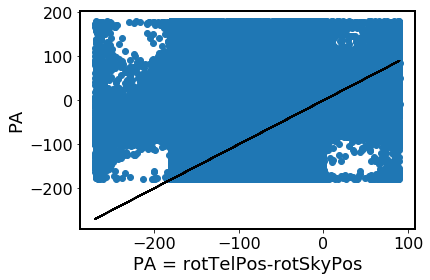

In [9]:
print('Considering %s'%db)
PA = simdatas[db]['rotTelPos']-simdatas[db]['rotSkyPos']
PA[PA<-180] += 180
plt.scatter(PA, simdatas[db]['PA'])
plt.plot(PA, PA, 'k')
plt.xlabel('PA = rotTelPos-rotSkyPos')
plt.ylabel('PA')
plt.show()

Okay this is strange. Not sure why is there comparison is so off. Lets just compare the distributions for rotSkyPos and rotTelPos:

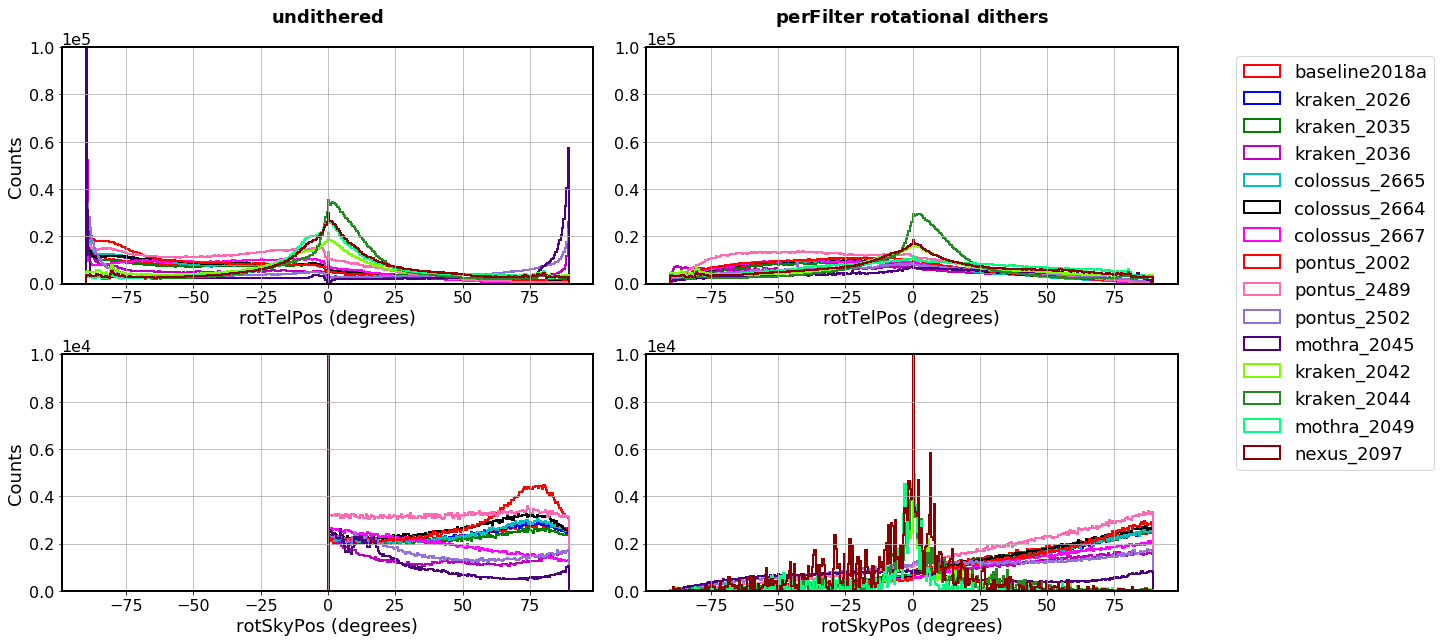

In [10]:
bins = np.arange(-90, 90, 0.5)
# histograms of dithers
nrows, ncols = 2,2
fig, axes = plt.subplots(nrows=nrows, ncols=ncols)
plt.subplots_adjust(hspace=0.3, wspace=0.1)

for i, db in enumerate(dbs):
    if db in simdatas:
        # undithered rotTelPos
        axes[0, 0].hist(simdatas[db]['rotTelPos'], bins=bins,
                        color=colors[i], histtype='step', lw=2)
        # dithered rotTelPos
        axes[0, 1].hist(simdatas[db]['randomDitherPerFilterChangeRotTelPos'],
                         label=db,
                        bins=bins, color=colors[i], histtype='step', lw=2)
        # undithered rotSkyPos
        axes[1, 0].hist(simdatas[db]['rotSkyPos'],
                        bins=bins, color=colors[i], histtype='step', lw=2)
        # dithered rotSkyPos
        PA = simdatas[db]['rotTelPos'] - simdatas[db]['rotSkyPos']
        axes[1, 1].hist(simdatas[db]['randomDitherPerFilterChangeRotTelPos']-PA,
                        bins=bins, color=colors[i], histtype='step', lw=2)

#ymax_tel, ymax_sky = 0, 0
#for col in range(ncols):
#    ymax_tel = max([ymax_tel, axes[0, col].get_ylim()[-1]])
#    ymax_sky = max([ymax_sky, axes[1, col].get_ylim()[-1]])
ymax_tel, ymax_sky = 10**5, 10**4
        
for row in range(nrows):
    for col in range(ncols):
        axes[0, col].set_ylim(0, ymax_tel)
        axes[1, col].set_ylim(0, ymax_sky)
        axes[row, col].ticklabel_format(style='sci', axis='y', scilimits=(0,0))
        axes[row, 0].set_ylabel('Counts')
        axes[0, col].set_xlabel('rotTelPos (degrees)')
        axes[1, col].set_xlabel('rotSkyPos (degrees)')
        axes[row, col].grid()
ymax_tel, ymax_sky = 0.5*10**5, 10**4
axes[0, 1].legend(bbox_to_anchor=(1.5,1))
axes[0, 0].set_title(r'$\bf{undithered}$', fontsize=fontsize, y=1.08)
axes[0, 1].set_title(r'$\bf{perFilter \ rotational \ dithers}$', fontsize=fontsize, y=1.08)
#plt.grid()
#filename = 'compare_median_nvisits_%sdbs.png'%(nDbs)
#plt.savefig('%s/%s'%(outDir, filename), format= 'png', bbox_inches='tight')
#print('Saved %s'%filename)
plt.gcf().set_size_inches(20,10)
plt.show()

Okay, dithered rotSkyPos doesn't look right so ParallacticAngleStacker appears to be the way to go.